# Unsupervised learning using Olivetti Faces

Suggested as an exercise in Aurelien Hands On Machine Learning

Focus:
    - KMeans and GMM clustering
    - PCA applications

In [1]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dict = fetch_olivetti_faces()

In [3]:
X = data_dict['data']
y = data_dict['target']

- Split training, test

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

- Find what n_clusters is best

In [5]:
inertia_list = []
silhouette_scores = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_train)
    
    inertia_list.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train ,kmeans.labels_, random_state=42))

Text(0.5, 0, 'Clusters')

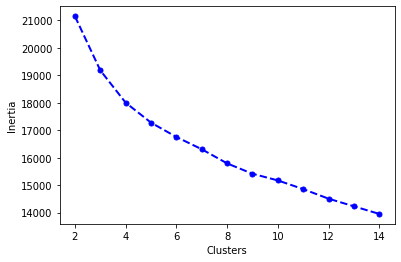

In [6]:
plt.plot(range(2, 15), inertia_list, 'bo--', linewidth=2, markersize=5)
plt.ylabel('Inertia')
plt.xlabel('Clusters')

Text(0.5, 0, 'Clusters')

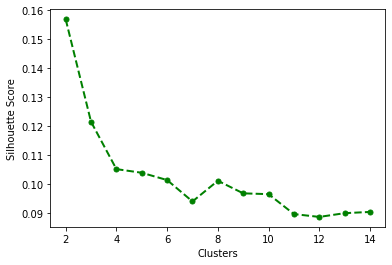

In [7]:
plt.plot(range(2, 15), silhouette_scores, 'go--', linewidth=2, markersize=5)
plt.ylabel('Silhouette Score')
plt.xlabel('Clusters')

- 11 Clusters seem to be the best

In [8]:
kmeans = KMeans(n_clusters=11, random_state=42, n_init=10)
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [9]:
def draw_faces(X_, title):
    fig, axes = plt.subplots(1, len(X_), figsize=(5,5))

    for i, X in enumerate(X_):
        axes[i].imshow(X, cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.title(title)  
    plt.show()

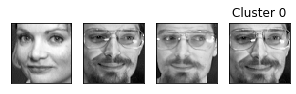

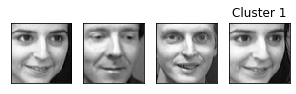

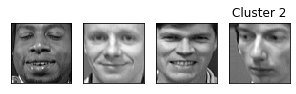

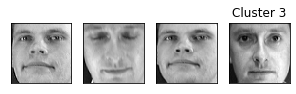

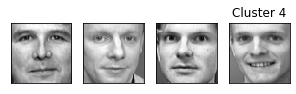

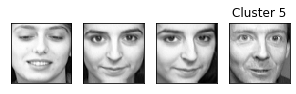

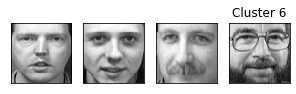

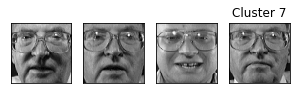

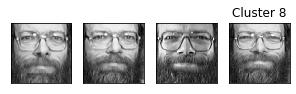

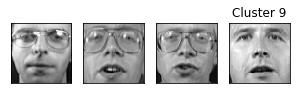

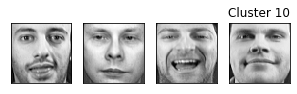

In [10]:
for label in set(kmeans.labels_):
    sample_size = 4
    idx = kmeans.labels_ == label
    
    X_cluster = X_train[idx].reshape(-1,64,64)
    sample_idx = np.random.choice(X_cluster.shape[0], size=sample_size, replace=False)
    
    draw_faces(X_cluster[sample_idx], "Cluster " + str(label))

- Classification of faces using only logistic regression

In [18]:
# log_reg = LogisticRegression(random_state=42, max_iter=200)

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# score = cross_val_score(log_reg, X_train, y_train, cv=kfold)

In [152]:
score.mean()

0.9499794274966202

- Attempt to use KMeans as pre-processing

In [11]:
params = {'kmeans__n_clusters': list(range(25,35))}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipeline1 = Pipeline([
    ('kmeans', KMeans(n_init=10, random_state=42)),
    ('log_reg', LogisticRegression(random_state=42, max_iter=200))
])

In [19]:
# search = GridSearchCV(pipeline1, params, scoring='accuracy', verbose=2, cv=kfold)

# search.fit(X_train, y_train)

In [146]:
search.best_params_

{'kmeans__n_clusters': 30}

In [147]:
# Dimensionality reduction by clustering did not improve the score

search.best_score_

0.8750073473226356

- We will train GMM by using PCA to increase speed

In [12]:
pipeline2 = Pipeline([
    ('pca', PCA(n_components=0.99, random_state=42)),
    ('gmm', GaussianMixture(n_init=10, random_state=42))
])

In [167]:
bic = []
aic = []

range_n_components = range(2, 10, 1)
for i in range_n_components:
    pipeline2.set_params(gmm__n_components=i)
    pipeline2.fit(X_train, y_train)
    bic.append(pipeline2['gmm'].bic(pipeline2['pca'].transform(X_train)))
    aic.append(pipeline2['gmm'].aic(pipeline2['pca'].transform(X_train)))
    print(str(i) + ' ', end='')

2 3 4 5 6 7 8 9 

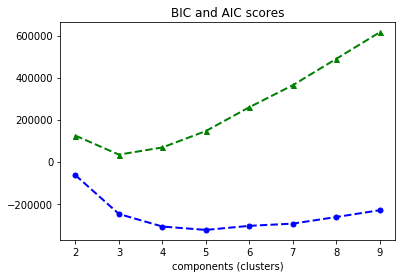

In [173]:
plt.plot(range_n_components, aic, 'bo--', linewidth=2, markersize=5)
plt.plot(range_n_components, bic, 'g^--', linewidth=2, markersize=5)
plt.title('BIC and AIC scores')
plt.xlabel('components (clusters)')
plt.show()

- Lets choose n_components = 3 for GaussianMixture

In [13]:
pipeline2.set_params(gmm__n_components=3)
pipeline2.fit(X_train, y_train)

pred_clusters = pipeline2.predict(X_train)
pcs = pipeline2['pca'].transform(X_train)

- Lets visualize the clusters. We will look at the first two PCs

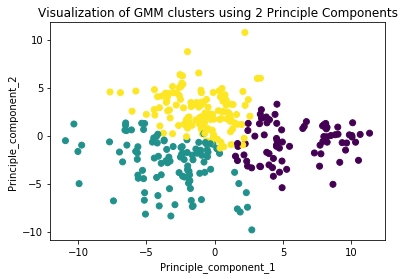

In [185]:
plt.scatter(pcs[:,0], pcs[:,1], c=pred_clusters)
plt.title('Visualization of GMM clusters using 2 Principle Components')
plt.xlabel('Principle_component_1')
plt.ylabel('Principle_component_2')
plt.show()

- Lets get some random samples from the GMM and regenerate the faces

In [14]:
sampled_pca_data = pipeline2['gmm'].sample(5)
sampled_data = pipeline2['pca'].inverse_transform(sampled_pca_data[0])

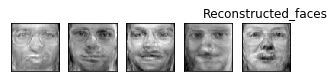

In [16]:
draw_faces(sampled_data.reshape(-1, 64, 64), "Reconstructed_faces")

- Anomaly detection using PCA

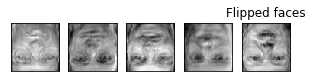

In [17]:
flipped_data = sampled_data.reshape(-1, 64, 64)[:, ::-1]
draw_faces(flipped_data, "Flipped faces")

flipped_data = flipped_data.reshape(-1, 4096)

In [286]:
# combined_data = np.r_[X_train, flipped_data]

pca = PCA(n_components=0.99, random_state=42)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [287]:
def get_reconstruction_err(pca, X):
    X_transform = pca.transform(X)
    X_reverted = pca.inverse_transform(X_transform)
    mse = ((X - X_reverted)**2).mean(axis=-1).mean()
    return mse

In [288]:
get_reconstruction_err(pca, X_train)

0.00018999894

- When combined_data is fitted into PCA, reconstruction err not so much. So it can only predict unseen outliers?

In [289]:
get_reconstruction_err(pca, flipped_data)

0.0058587397938374445